### Install packages

In [1]:
# !pip install -U pip
# !pip install -U setuptools wheel
# !pip install "numpy<2.0.0"  # Fix compatibility issue with AutoGluon
# !pip install -U "mxnet<2.0.0" bokeh==2.0.1
# !pip install autogluon --no-cache-dir
# !pip install kaggle

### Setup Kaggle API Key

In [2]:
# import os
# kaggle_dir = os.path.expanduser("~/.kaggle")
# !mkdir -p {kaggle_dir}
# !touch {kaggle_dir}/kaggle.json
# !chmod 600 {kaggle_dir}/kaggle.json

In [ ]:
# Fill in your user name and key from creating the kaggle account and API token file
# import json
# import os
# kaggle_username = "vbustillo"
# kaggle_key = "4a62006bdac26949783ce007d3ed2c8e"

# Save API token to the kaggle.json file in the user's home directory
# kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
# with open(kaggle_path, "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [ ]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
# !kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
# !unzip -o bike-sharing-demand.zip -d input/

In [ ]:
# Move existing data files to input directory (run this once if files are in current directory)
import os
import shutil

# Create directories if they don't exist
os.makedirs('input', exist_ok=True)
os.makedirs('submissions', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Move data files to input directory if they exist in current directory
data_files = ['train.csv', 'test.csv', 'sampleSubmission.csv']
for file in data_files:
    if os.path.exists(file) and not os.path.exists(f'input/{file}'):
        shutil.move(file, f'input/{file}')
        print(f"Moved {file} to input/{file}")
    elif os.path.exists(f'input/{file}'):
        print(f"input/{file} already exists")
    else:
        print(f"{file} not found - you may need to download it first")

print("\nDirectory structure created:")
print("- input/: Contains train.csv, test.csv, sampleSubmission.csv")
print("- models/: Will contain trained AutoGluon models")
print("- submissions/: Will contain generated submission files")

### Import Packages

In [7]:
%load_ext autoreload
%autoreload 2

import json
import os
import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
from modeling_pipeline import data_process, train_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Read data and transform it accordingly

In [ ]:
train = pd.read_csv("input/train.csv", parse_dates=["datetime"])
test = pd.read_csv("input/test.csv", parse_dates=["datetime"])
submission = pd.read_csv("input/sampleSubmission.csv")

In [ ]:
numerical_features = [
    'temp', 'atemp', 'humidity', 'windspeed'
]

categorical_features = [
    'season', 'holiday', 'workingday', 'weather',
    'hour', 'dayofweek', 'month',
    'is_morning', 'is_evening', 'is_night',
    'temp_quart', 'atemp_quart', 'humidity_quart', 'windspeed_quart'
    ,'meteo_bin'
]

In [32]:
train, test = data_process.numerical_to_quartiles(train, test, numerical_features)

train = data_process.enrich_featureset(train, categorical_features)
test = data_process.enrich_featureset(test, categorical_features)

train_log = data_process.create_log_transformed_data(train, target_col='count')
train_log = data_process.create_log_transformed_data(train_log, target_col='casual')
train_log = data_process.create_log_transformed_data(train_log, target_col='registered')

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:130: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


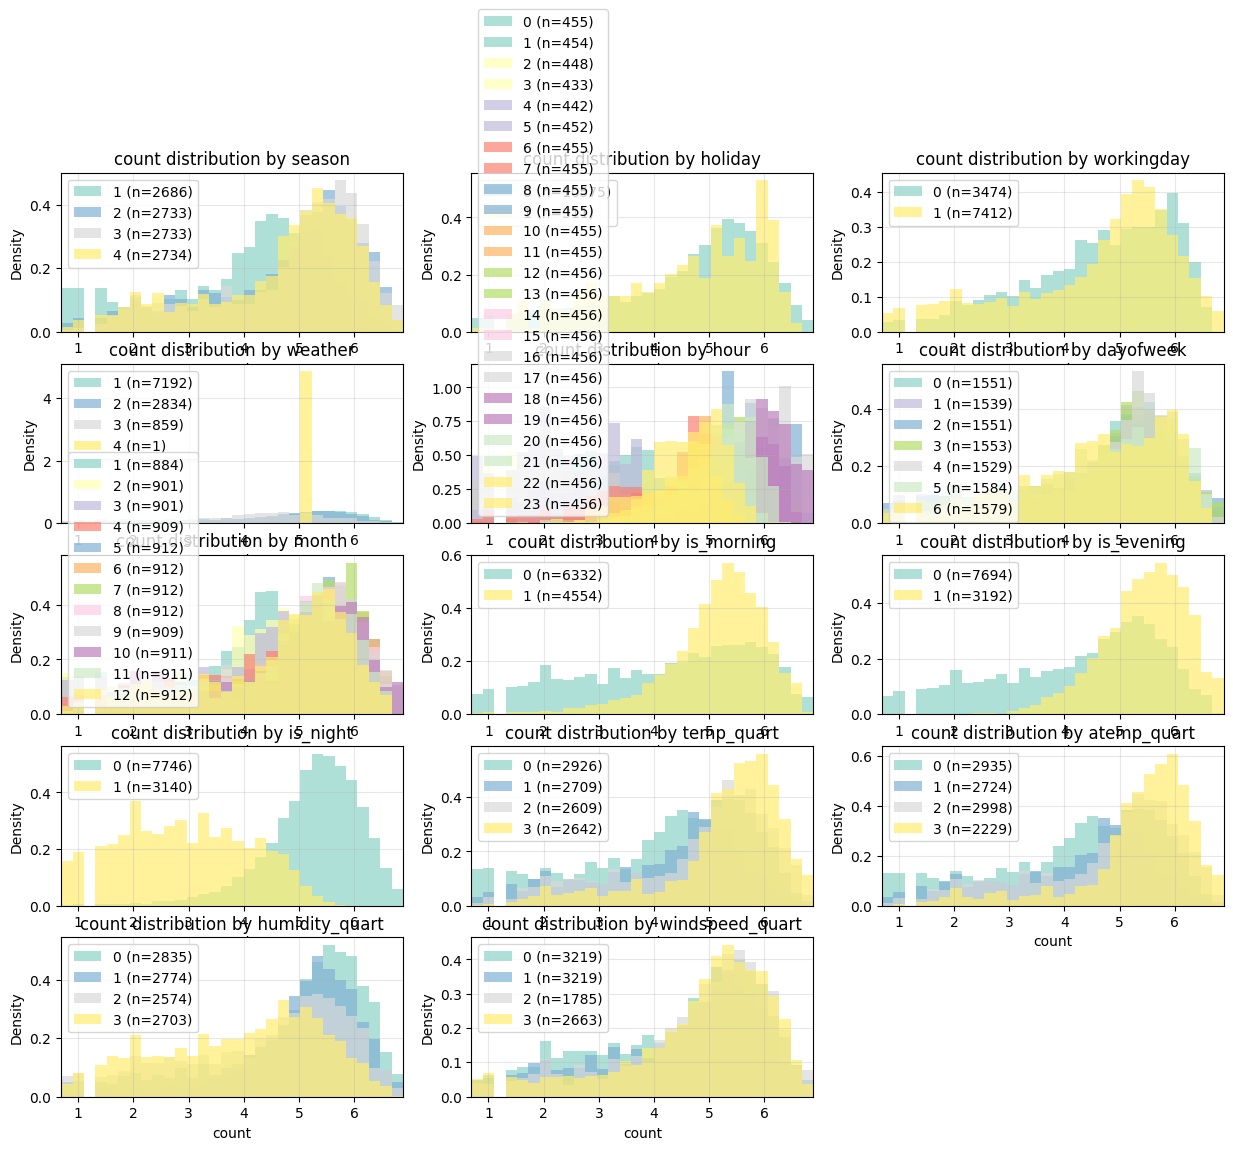

In [36]:
# Analyze target distribution across categorical features
data_process.plot_target_vs_categorical_features(
    df=train_log, 
    categorical_features=categorical_features, 
    target_col='count',
    figsize=(15, 12)
)

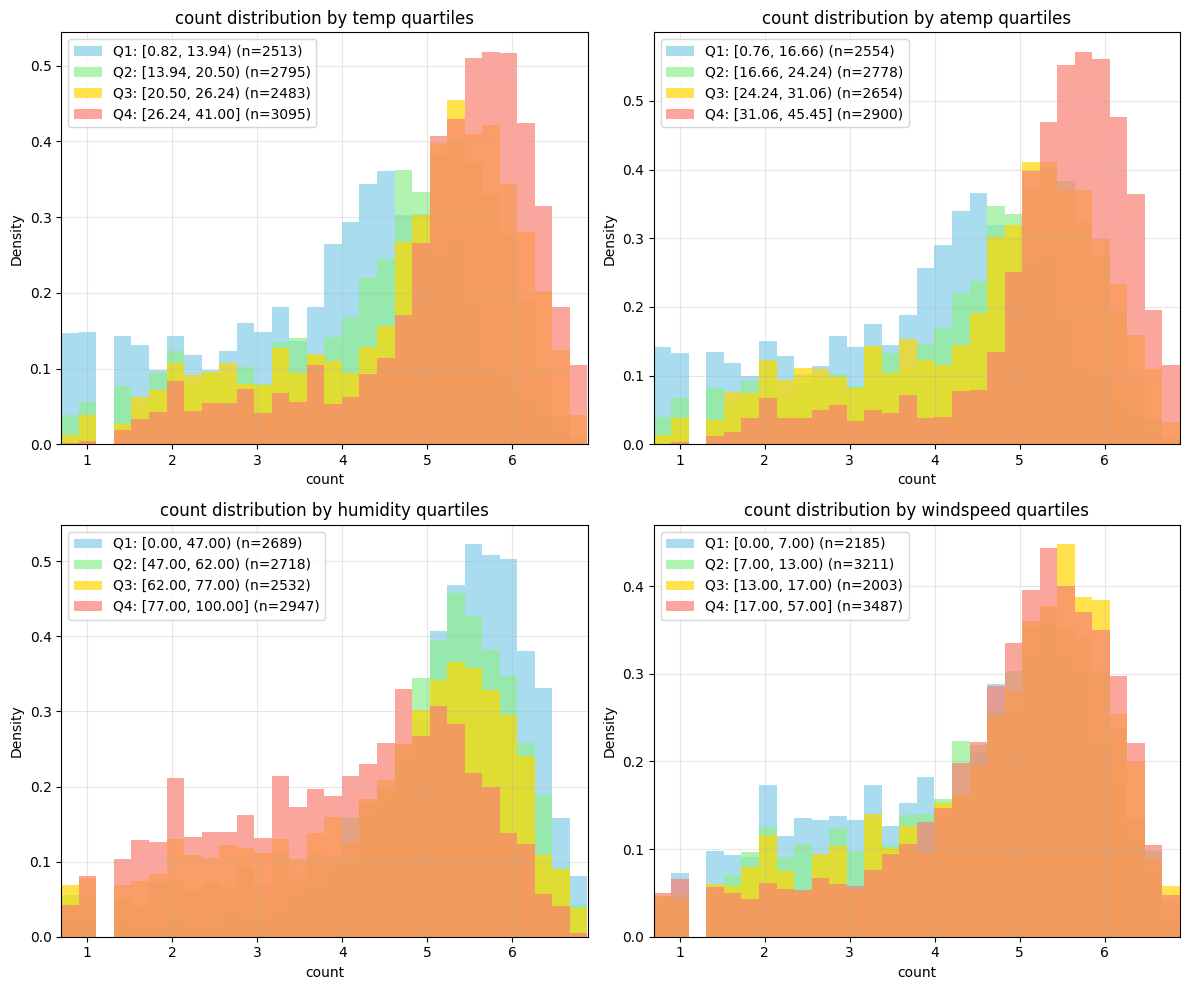


Summary statistics for count by numerical feature quartiles:

temp:
          count  mean   std   min   max
quartile                               
Q1         2926  3.90  1.43  0.69  6.59
Q2         2709  4.52  1.37  0.69  6.73
Q3         2609  4.77  1.36  0.69  6.88
Q4         2642  5.25  1.14  0.69  6.89
Quartile boundaries: ['0.82', '13.94', '20.50', '26.24', '41.00']

atemp:
          count  mean   std   min   max
quartile                               
Q1         2935  3.93  1.43  0.69  6.67
Q2         2724  4.50  1.38  0.69  6.73
Q3         2998  4.77  1.36  0.69  6.89
Q4         2229  5.34  1.08  1.10  6.88
Quartile boundaries: ['0.76', '16.66', '24.24', '31.06', '45.45']

humidity:
          count  mean   std   min   max
quartile                               
Q1         2835  5.21  1.08  0.69  6.89
Q2         2774  4.77  1.36  0.69  6.80
Q3         2574  4.38  1.49  0.69  6.82
Q4         2703  3.96  1.42  0.69  6.73
Quartile boundaries: ['0.00', '47.00', '62.00', '77.00', '10

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:232: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df_temp.groupby('quartile')[target_col].agg(['count', 'mean', 'std', 'min', 'max'])
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_process.py:232: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_stats = df_temp.groupby('quartile')[target_col].agg(['count', 'mean', 'std', 'min', 'max'])
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/project/modeling_pipeline/data_p

In [6]:
# Analyze target distribution across quartiles of numerical features
data_process.plot_target_vs_numerical_features_quartiles(
    df=train_log, 
    numerical_features=numerical_features, 
    target_col='count',
    figsize=(12, 10)
)

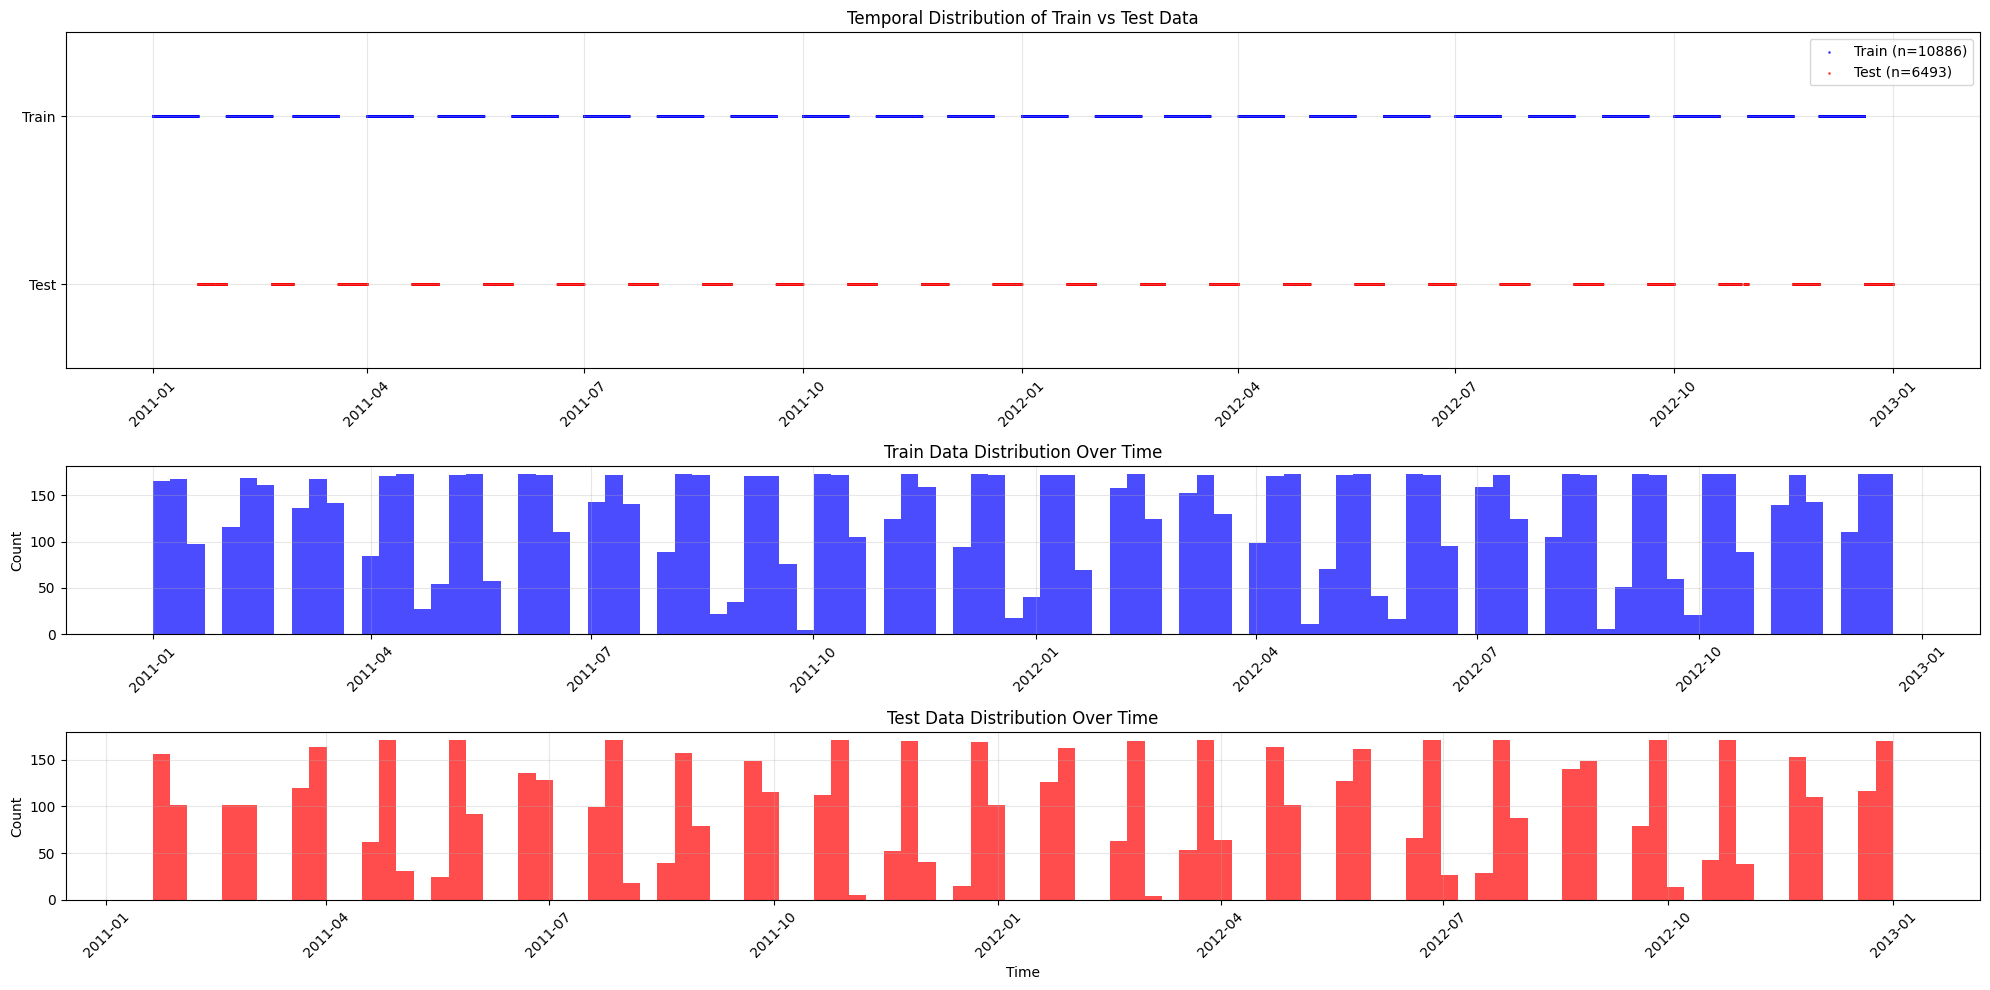

Temporal Data Summary:
Train data period: 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Test data period: 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Train duration: 718 days
Test duration: 711 days
Overlap period: 2011-01-20 00:00:00 to 2012-12-19 23:00:00
Overlap duration: 699 days
Train and test periods overlap or are adjacent


In [45]:
# Visualize temporal distribution of train vs test data
data_process.plot_temporal_data_distribution(
    train_df=train, 
    test_df=test, 
    datetime_col='datetime',
    figsize=(20, 10)
)

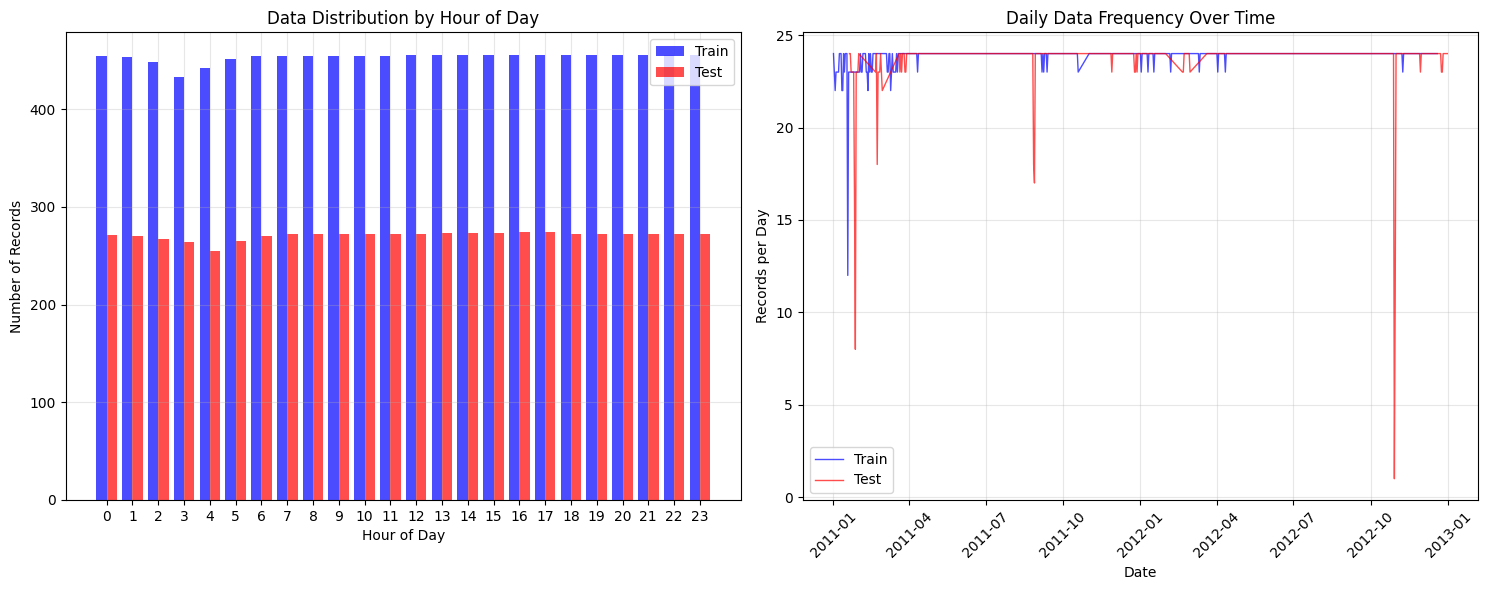

In [44]:
# Analyze hourly patterns in train vs test data
data_process.plot_hourly_patterns(
    train_df=train, 
    test_df=test, 
    datetime_col='datetime',
    figsize=(15, 6)
)

In [37]:
print("New features created and log transformation applied!")
print(f"Train shape: {train_log.shape}")
print(f"Test shape: {test.shape}")
print(f"Log-transformed target range: {train_log['count'].min():.4f} to {train_log['count'].max():.4f}")
print(f"Log-transformed target range: {train_log['casual'].min():.4f} to {train_log['casual'].max():.4f}")
print(f"Log-transformed target range: {train_log['registered'].min():.4f} to {train_log['registered'].max():.4f}")
train_log.head(3)

New features created and log transformation applied!
Train shape: (10886, 22)
Test shape: (6493, 19)
Log-transformed target range: 0.6931 to 6.8855
Log-transformed target range: 0.0000 to 5.9081
Log-transformed target range: 0.0000 to 6.7878


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,temp_quart,atemp_quart,humidity_quart,windspeed_quart,hour,month,dayofweek,is_morning,is_evening,is_night
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,1.386294,...,0,0,3,0,0,1,5,0,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2.197225,...,0,0,3,0,1,1,5,0,0,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,1.791759,...,0,0,3,0,2,1,5,0,0,1


## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

### Train General model (registered + casual)

In [ ]:
predictor_general = train_pipeline.regression_autogluon(
    train_df=train_log,
    feature_cols=categorical_features + numerical_features,
    target_col='count',
    time_limit=1200,
    path='models/bike_sharing_general_v02'
)

2025-07-27 13:49:25,270	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-27 13:49:26,511	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
(_dystack pid=41443) /Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/autogluon/common/utils/utils.py:97: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
(_dystack pid=41443)   import pkg_resources
(_dystack pid=41443) /Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.val

In [47]:
# Make predictions with the new feature model
predictions_log_general = predictor_general.predict(test, as_pandas=True)

# Transform predictions back from log space
predictions_general = data_process.inverse_log_transform(predictions_log_general)

print(f"Predictions range: {predictions_general.min():.2f} to {predictions_general.max():.2f}")


Predictions range: 1.53 to 828.91


In [48]:
predictor_general.fit_summary(verbosity=1, show_plot=False)

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       WeightedEnsemble_L3  -0.332233  root_mean_squared_error       2.778704  370.949200                0.000244           0.019293            3       True         24
1       WeightedEnsemble_L2  -0.334245  root_mean_squared_error       2.107419  255.581996                0.000569           0.020486            2       True         12
2         CatBoost_2_BAG_L2  -0.335399  root_mean_squared_error       2.383247  345.460905                0.044158          45.005046            2       True         17
3           CatBoost_BAG_L2  -0.335737  root_mean_squared_error       2.373889  323.622256                0.034800          23.166397            2       True         16
4       ExtraTrees_2_BAG_L2  -0.335982  root_mean_squared_error       2.539977  301.457698   

{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'RandomForest_2_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'CatBoost_2_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'ExtraTrees_2_BAG_L1': 'StackerEnsembleModel_XT',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_2_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_3_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'RandomForest_2_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'CatBoost_2_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L2': 'Stac

In [ ]:
# Create submission dataframe for new features model
submission_general = pd.read_csv('input/sampleSubmission.csv')
submission_general["count"] = predictions_general
submission_general.to_csv("submissions/submission_gen_new_features.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_gen_new_features.csv -m "clean pipeline new features"

100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 48.8kB/s]
100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 48.8kB/s]
Successfully submitted to Bike Sharing DemandSuccessfully submitted to Bike Sharing Demand

In [51]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                         date                        description                                status                     publicScore  privateScore  
-------------------------------  --------------------------  -----------------------------------------  -------------------------  -----------  ------------  
submission_gen_new_features.csv  2025-07-27 12:07:51         clean pipeline new features                SubmissionStatus.COMPLETE  0.43527      0.43527       
submission_gen_new_features.csv  2025-07-27 12:02:16.643000  clean pipeline new features                SubmissionStatus.COMPLETE  0.43527      0.43527       
submission_combined.csv          2025-07-27 10:27:05         combined predictions submission            SubmissionStatus.COMPLETE  0.43917      0.43917       
submission_general.csv           2025-07-27 10:01:14.297000  clean pipeline submission                  SubmissionStatus.COMPLETE  0.43654      0.43654       


### Train individual models (registered and casual)

In [ ]:
predictor_registered = train_pipeline.regression_autogluon(
    train_df=train_log,
    feature_cols=categorical_features + numerical_features,
    target_col='registered',
    time_limit=1200,
    path='models/bike_sharing_registered'
)

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. T

In [ ]:
predictor_casual = train_pipeline.regression_autogluon(
    train_df=train_log,
    feature_cols=categorical_features + numerical_features,
    target_col='casual',
    time_limit=1200,
    path='models/bike_sharing_casual'
)

/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/victorbustillo/Documents/D01 GitHub/cd0385-project-starter/venv39/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. T

In [46]:
# Make predictions with the new feature model
predictions_log_registered = predictor_registered.predict(test, as_pandas=True)
predictions_log_casual = predictor_casual.predict(test, as_pandas=True)

# Transform predictions back from log space
predictions_registered = data_process.inverse_log_transform(predictions_log_registered)
predictions_casual = data_process.inverse_log_transform(predictions_log_casual)

print(f"Predictions range: {predictions_registered.min():.2f} to {predictions_registered.max():.2f}")
print(f"Predictions range: {predictions_casual.min():.2f} to {predictions_casual.max():.2f}")

predictions_final = predictions_registered + predictions_casual
print(f"Final predictions range: {predictions_final.min():.2f} to {predictions_final.max():.2f}")

NameError: name 'predictor_registered' is not defined

In [ ]:
# Create submission dataframe for new features model
submission_combined = pd.read_csv('input/sampleSubmission.csv')
submission_combined["count"] = predictions_final
submission_combined.to_csv("submissions/submission_combined.csv", index=False)

In [ ]:
!kaggle competitions submit -c bike-sharing-demand -f submissions/submission_combined.csv -m "combined predictions submission"

100%|████████████████████████████████████████| 188k/188k [00:03<00:00, 60.1kB/s]
Successfully submitted to Bike Sharing Demand

In [37]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                        date                        description                                status                     publicScore  privateScore  
------------------------------  --------------------------  -----------------------------------------  -------------------------  -----------  ------------  
submission_combined.csv         2025-07-27 10:27:05         combined predictions submission            SubmissionStatus.COMPLETE  0.43917      0.43917       
submission_general.csv          2025-07-27 10:01:14.297000  clean pipeline submission                  SubmissionStatus.COMPLETE  0.43654      0.43654       
submission_general.csv          2025-07-27 09:37:25.157000  clean pipeline submission                  SubmissionStatus.COMPLETE  0.43654      0.43654       
submission_clean_nb.csv         2025-07-26 20:53:13         clean notebook                             SubmissionStatus.COMPLETE  0.41055      0.41055       
